In [50]:
import numpy as np
from sklearn.linear_model import LassoCV, ElasticNetCV, lasso_path, enet_path, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from modopt.opt.proximity import KSupportNorm, SparseThreshold, ElasticNet
from modopt.opt.linear import Identity
from sklearn.preprocessing import normalize, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 29


In [34]:
rs = np.random.RandomState(2)
w11, w12, w13 = 9/11, 6/11, 2/11
w21, w22, w23 = 1/3, 14/15, 2/15
w31, w32, w33 = 1, 1, -4
X1 = rs.randn(4)
X2 = rs.randn(4)
X3 = rs.randn(4)
X4 = w11 * X1 + w12 * X2 + w13 * X3
X5 = w21 * X1 + w22 * X2 + w23 * X3
x0 = np.array([w31, w32, w33, 0., 0.])
y = w31 * X1 + w32 * X2 + w33 * X3
X = np.hstack([X1[:, None], X2[:, None], X3[:, None], X4[:, None], X5[:, None]])

In [35]:
X /= 4
y /= 4

In [36]:
def run_irksn(n_iter):
    alpha = 0.001
    k = 3
    beta = np.zeros(X.shape[1])
    v = np.zeros(X.shape[0])
    z = np.zeros(X.shape[0])
    z_old = np.zeros(X.shape[0])
    nuclear_norm = np.linalg.norm(X, ord='nuc')
    gamma = 0.5 * alpha * nuclear_norm**(-2)
    theta = 1
    prox = KSupportNorm(beta=(1 - alpha)/alpha, k_value=k)
    losses, sparsity = [], []
    betas = []
    print((2 * nuclear_norm * np.linalg.norm(np.linalg.pinv(X[:, :3].T) @ x0[:3]))/alpha)
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        
        beta = prox.op(- 1/alpha * X.T @ z)
        r = prox.op(- 1/alpha * X.T @ v)
        z_old = z + 0.
        z = v + gamma * (X @ r - y)
        theta_old = theta + 0.
        theta = (1 + np.sqrt(1 + 4 * theta ** 2))/2
        v = z + (theta_old - 1)/(theta) * (z - z_old)
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [37]:
def gradirosr(X, u, v, y):
    residual = (X @ (u * u - v * v) - y)
    return (2/X.shape[0] * X.T * u[:, None] @ (residual), -2/X.shape[0] * X.T * v[:, None] @ (residual))

def run_irosr(n_iter):
    eta = 0.1
    alpha = 0.1
    u, v = alpha * np.ones(X.shape[1]), alpha * np.zeros(X.shape[1])
    beta = u**2 - v** 2
    losses, sparsity, betas = [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        u_grad, v_grad = gradirosr(X, u, v, y)
        u -= eta * u_grad
        v -= eta * v_grad
        beta = u**2 - v** 2
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [38]:
def shrink(u, tau, factor=1.):
    """Soft-thresholding of vector u at level tau > 0."""
    return np.sign(u) * np.maximum(0., np.abs(u) - tau)

def run_ircr(n_iter):
    beta = np.zeros(X.shape[1])
    beta_sum = beta + 0.
    beta_avg = beta + 0.
    theta = np.zeros(X.shape[0])
    theta_old = theta + 0.
    nuclear_norm = np.linalg.norm(X, ord='nuc')
    tau = 0.9 * 1/np.sqrt(2 * nuclear_norm**2)
    sigma = 0.9 * 1/np.sqrt(2 * nuclear_norm**2)
    losses, sparsity, betas = [], [], []

    for it in range(n_iter):
        betas.append(beta_avg[:, None])
        sparsity.append(np.count_nonzero(beta_avg))
        losses.append(np.linalg.norm(x0 - beta_avg))
        beta = shrink(beta - tau * X.T @ (2 * theta - theta_old), tau)
        theta_old = theta + 0.
        theta = theta_old + sigma * (X @ beta - y)
        beta_sum = beta_sum + beta
        beta_avg = beta_sum / it
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [39]:
def hard_threshold(arr, k):
    top_k_indices = np.argpartition(np.abs(arr), -k)[-k:]
    thresholded_arr = np.zeros_like(arr)
    thresholded_arr[top_k_indices] = arr[top_k_indices]
    return thresholded_arr

def run_iht(n_iter):
    eta = 0.01
    k = 3
    beta = np.zeros(X.shape[1])
    losses, sparsity, betas = [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        beta -= eta * 1/X.shape[0] * X.T @ (X @ beta - y)
        beta = hard_threshold(beta, int(k))
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [40]:
def firosr(X, u, v, y):
    return 1/(2 * X.shape[0]) * np.sum((X @ (u * u - v * v) - y)**2)

def gradirosr(X, u, v, y):
    residual = (X @ (u * u - v * v) - y)
    return (2/X.shape[0] * X.T * u[:, None] @ (residual), -2/X.shape[0] * X.T * v[:, None] @ (residual))


def run_irosr(n_iter):
    eta = 0.001
    alpha = 1
    u, v = alpha * np.ones(X.shape[1]), alpha * np.zeros(X.shape[1])
    beta = u**2 - v** 2
    losses, sparsity, betas = [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        u_grad, v_grad = gradirosr(X, u, v, y)
        u -= eta * u_grad
        v -= eta * v_grad
        beta = u**2 - v** 2
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [41]:
def run_srdi(n_iter):
    kappa, alpha = 0.1, 0.1
    min_val_loss = np.infty
    curr_loss = np.infty
    z = np.zeros(X.shape[1])
    beta = np.zeros(X.shape[1])
    losses, sparsity, betas = [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        z = z + alpha/X.shape[1] * X.T @ (y - X @ beta)
        beta = kappa * shrink(z, 1)
    betas = np.hstack(betas)
    return sparsity, losses, betas

# Plotting

In [42]:
n_iter = 10000
sparsity_ircr, losses_ircr, betas_ircr = run_ircr(n_iter)
sparsity_irksn, losses_irksn, betas_irksn = run_irksn(n_iter)
sparsity_iht, losses_iht, betas_iht = run_iht(n_iter)
sparsity_irosr, losses_irosr, betas_irosr = run_irosr(n_iter)
sparsity_srdi, losses_srdi, betas_srdi = run_srdi(n_iter)

/var/folders/0k/3wpd9xq16431qnr10wd2lx8h0000gp/T/ipykernel_96050/1337718237.py:24: RuntimeWarning: invalid value encountered in divide
  beta_avg = beta_sum / it


38122.48866911708


/Users/william.vezelhes/miniconda3/envs/ksn/lib/python3.11/site-packages/modopt/opt/proximity.py:1021: RuntimeWarning: divide by zero encountered in scalar divide
  return (self._k_value - b_val) / slope


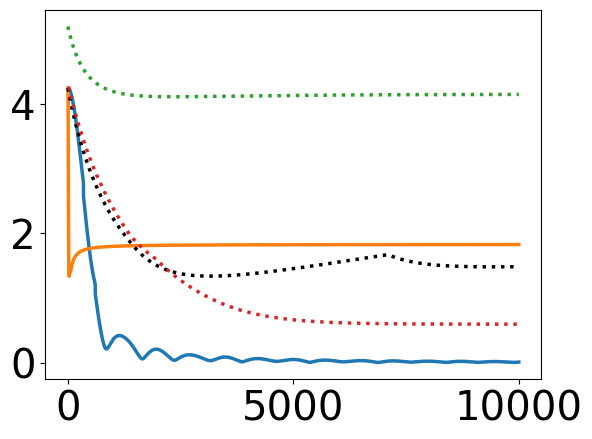

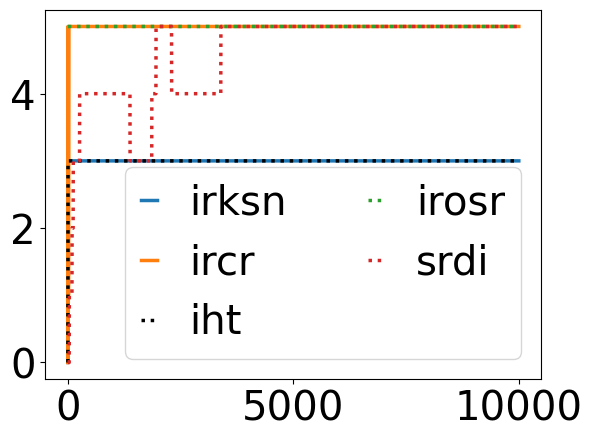

In [58]:



plt.figure()
plt.plot(losses_irksn, label='irksn', linestyle='-', linewidth=2.5)
plt.plot(losses_ircr, label='ircr', linestyle='-', linewidth=2.5)
plt.plot(losses_iht, label='iht', linestyle=':', linewidth=2.5, color='black')
plt.plot(losses_irosr, label='irosr', linestyle=':', linewidth=2.5)
plt.plot(losses_srdi, label='srdi', linestyle=':', linewidth=2.5)
# plt.legend()
# plt.title('Model Error')


plt.figure()
plt.plot(sparsity_irksn, label='irksn', linestyle='-', linewidth=2.5)
plt.plot(sparsity_ircr, label='ircr', linestyle='-', linewidth=2.5)
plt.plot(sparsity_iht, label='iht', linestyle=':', linewidth=2.5, color='black')
plt.plot(sparsity_irosr, label='irosr', linestyle=':', linewidth=2.5)
plt.plot(sparsity_srdi, label='srdi', linestyle=':', linewidth=2.5)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handlelength=0.3)
# 
plt.legend(handlelength=0.4, loc='lower right', ncol=2)
# plt.title('Sparsity')